In [743]:
import pandas as pd
import numpy as np
import csv
import ast
from datetime import datetime
import collections
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
mpl.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.family'] = 'NanumBarunGothic'
plt.rcParams['font.size'] = 11.5
plt.rcParams['figure.figsize'] = (14,4)

In [995]:
naver_review = pd.read_csv('/Users/dhkim/PycharmProjects/RealTastySpot/data/네이버리뷰/naver_review.txt')
kakao_review = pd.read_excel('/Users/dhkim/PycharmProjects/RealTastySpot/data/카카오리뷰/kakao_review.xlsx')
google_review = pd.read_excel('/Users/dhkim/PycharmProjects/RealTastySpot/data/구글리뷰/google_reviews.xlsx')
mango_review = pd.read_excel('/Users/dhkim/PycharmProjects/RealTastySpot/data/망고플레이트/mangoplates_reviews.xlsx')
dinning_review = pd.read_excel('/Users/dhkim/PycharmProjects/RealTastySpot/data/다이닝코드/dinning_review_reshape.xlsx')
dining_like = pd.read_excel('/Users/dhkim/PycharmProjects/RealTastySpot/data/다이닝코드/dinningcode_review_like.xlsx')

# MANGO PLAETE 가격대별 가성비 카테고리 만들기

In [996]:
mango_review.loc[26, 'category'] = '기타 한식'
mango_review.loc[26, 'prices'] = '만원 미만'

In [997]:
for idx, price in enumerate(mango_review.prices):
    price_num = 1.0
    if price == '만원-2만원':
        price_num = 2.0
    elif price == '2만원-3만원':
        price_num = 3.0
    elif price == '3만원-4만원':
        price_num = 4.0
    elif price == '4만원 이상':
        price_num = 5.0
        
    mango_review.loc[idx, 'prices_num'] = price_num

In [998]:
mean_prices = mango_review.groupby('category')['prices_num'].mean()

In [999]:
for idx, price in enumerate(mango_review.prices_num):
    category = mango_review.loc[idx, 'category']
    mango_review.loc[idx, 'relative_price'] = price / mean_prices[category]

In [1000]:
for idx, price in enumerate(mango_review.relative_price):
    # 0.4 미만 - 가성비 훌륭함 (5점)
    # 0.4 ~ 1.0 - 가성비 좋음 (4점)
    # 1.0 - 가성비 그저 그럼, 평균 (3점)
    # 1 ~ 2 - 가성비 나쁨 (2점)
    # 2 ~ - 가성비 극악 (1점)
    if price < 0.4:
        price_grade = 5
    elif price < 1:
        price_grade = 4
    elif price == 1.0:
        price_grade = 3
    elif price < 2:
        price_grade = 2
    else:
        price_grade = 1

    mango_review.loc[idx, 'price_grade'] = price_grade

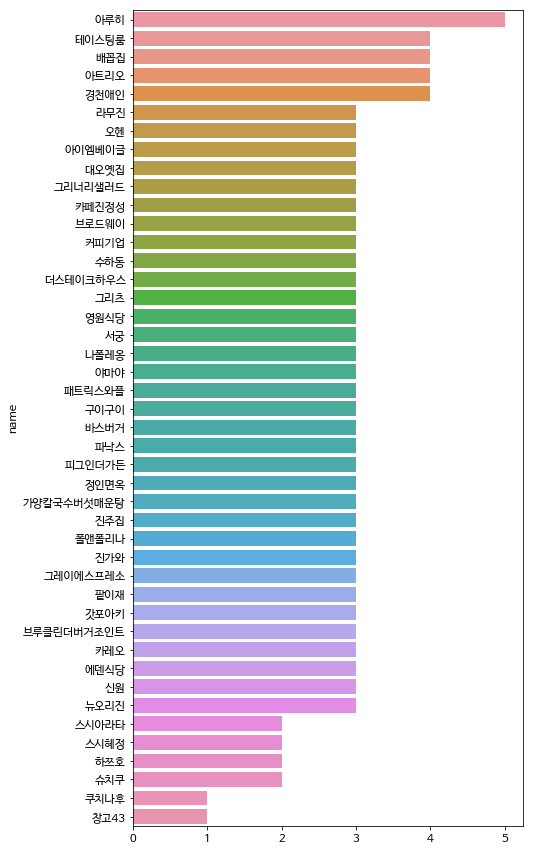

In [1001]:
plt.figure(figsize=(7,15))
price_grade_mango = mango_review.sort_values('price_grade', ascending=False).reset_index(drop=True)
sns.barplot(price_grade_mango.price_grade.values, price_grade_mango.name)

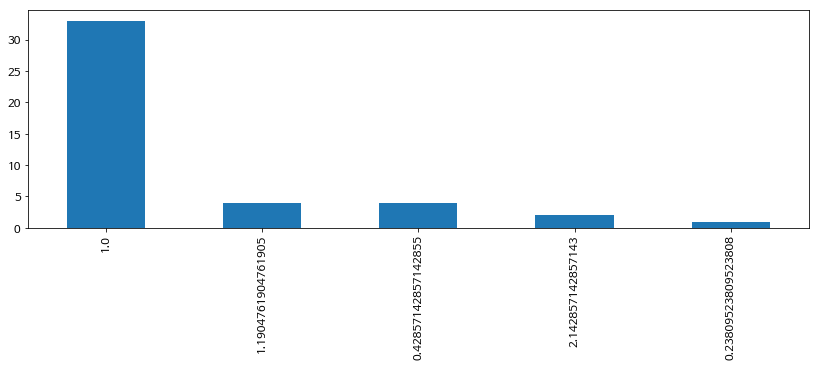

In [1002]:
mango_review.relative_price.value_counts().plot(kind='bar')
# 0.4 미만 - 가성비 훌륭함 (5점)
# 0.4 ~ 1.0 - 가성비 좋음 (4점)
# 1.0 - 가성비 그저 그럼, 평균 (3점)
# 1 ~ 2 - 가성비 나쁨 (2점)
# 2 ~ - 가성비 극악 (1점)

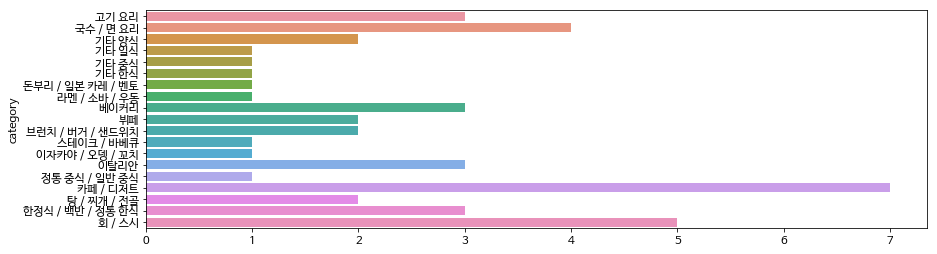

In [1003]:
sns.barplot(mango_review.groupby('category')['prices_num'].count().values, mango_review.groupby('category')['prices_num'].count().index)

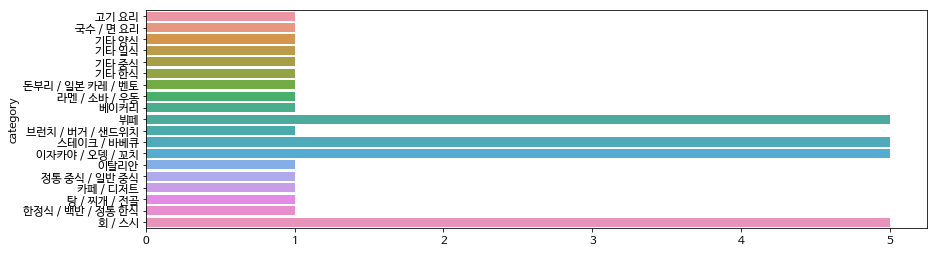

In [1004]:
sns.barplot(mango_review.groupby('category')['prices_num'].median().values, mango_review.groupby('category')['prices_num'].median().index)

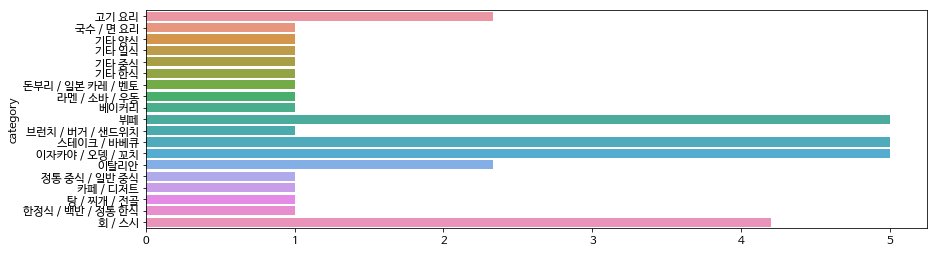

In [1005]:
sns.barplot(mango_review.groupby('category')['prices_num'].mean().values, mango_review.groupby('category')['prices_num'].mean().index)

## NAVER REVIEWS , SCORES , DATES 비교
- 브로드웨이, 아루히, 그리츠 다시 크롤링 후 재저장

In [1006]:
# naver_review_add = pd.read_csv('data/2020-09-03_16_20_link_review.txt', sep='\t').drop('Unnamed: 0', axis=1)
# naver_review_add
# naver_review_add = check_crwal_results(naver_review_add)
# naver_review = check_crwal_results(naver_review)
# naver_review = naver_review[naver_review_add.columns]
# naver_review = naver_review[(naver_review.name!='브로드웨이')&(naver_review.name!='아루히')&(naver_review.name!='그리츠')].reset_index(drop=True)
# naver_review = pd.concat([naver_review_add, naver_review]).sort_values('rank').reset_index(drop=True)
# naver_review = check_crwal_results(naver_review.copy())
# naver_review.to_csv('naver_review.txt', index=False)

In [1007]:
def check_crwal_results(df):
    for i, dates_str in enumerate(df['dates']):
        if dates_str[-1] != '}':
            dates_str = dates_str+'\'}'
        try:
            dates_dict = ast.literal_eval(dates_str)
        except Exception as e:
            print(f'{i}th {e}, {dates_str}')
            dates_str = dates_str.replace('nan', '\'\'')
            dates_dict = ast.literal_eval(dates_str)
        df.loc[i, 'dates_num'] = len(dates_dict)

    for i, scores_str in enumerate(df['scores']):
        try:
            scores_str= scores_str.replace('nan',"\'\'")
        except Exception as e:
            print(f'{i}th {e}, {scores_str}')
        try:
            scores_dict = ast.literal_eval(scores_str)
            df.loc[i, 'scores_num'] = len(scores_dict)
        except Exception as e:
            print(f'{i}th {e}, {scores_str}')

    for i, reviews_str in enumerate(df['reviews']):
        reviews_str = reviews_str.replace('nan', '\'\'')
        try:
            reviews_dict = ast.literal_eval(reviews_str)
        except Exception as e:
            print(f'{i}th {e}, {reviews_str[-50:]}')
            if reviews_str[-1] in str(list(range(10))).replace('[', '').replace(']', '').replace(' ', '').split(','):
                reviews_str = reviews_str[:-3] + '}'
            else:
                reviews_str = reviews_str+ '\'}'
            reviews_dict = ast.literal_eval(reviews_str)
        df.loc[i, 'reviews_num'] = len(reviews_dict)
    return df

# KAKAO reveiw 수정

In [1008]:
# kakao_3add = pd.read_csv('/Users/dhkim/PycharmProjects/RealTastySpot/code/data/2020-09-02_22_04_linkkakao_review.csv', sep='\t').drop('Unnamed: 0', axis=1)
# kakao_review = kakao_review.loc[:40]
# kakao_review = pd.concat([kakao_review, kakao_3add])
# kakao_review.to_excel('/Users/dhkim/PycharmProjects/RealTastySpot/data/카카오리뷰/kakao_review.xlsx', index=False)

# Mango review, Google review 수정

In [1009]:
mango_review.loc[7, 'allreviews'] = mango_review.allreviews[7] + mango_review.allreviews2[7]

In [1010]:
mango_review.loc[7, 'allreviews'] = mango_review.allreviews[7][:-2]

In [1011]:
google_review.loc[9, 'allreviews'] = google_review.allreviews[9] + google_review.allreviews2[9] + google_review.allreviews3[9]

In [1012]:
google_review.loc[7, 'allreviews'] = google_review.allreviews[7] + google_review.allreviews2[7] + google_review.allreviews3[7]

In [1013]:
google_review.loc[4, 'allreviews'] = google_review.allreviews[4] + google_review.allreviews2[4]

In [1014]:
google_review = google_review.drop(['allreviews2','allreviews3'], axis=1)

In [1015]:
mango_review = mango_review.drop('allreviews2', axis=1)

## google 4번과 9번의 경우 seperator가 달라 나머지 장소와 동일하게 '-'로 변경

In [1016]:
new_str = ''
for idx, x in enumerate(google_review.loc[4, 'allreviews'].split('}')):
    try:
        temp = x.split(':')
        new_str += ''.join([temp[0], ': ', temp[2].strip(), ' -', temp[1].strip(), '-', temp[3].strip(), '}'])
    except Exception as e:
        print(f'{idx}, {e}, {x}')
google_review.loc[4, 'allreviews'] = new_str

968, list index out of range, "


In [1017]:
new_str = ''
for idx, x in enumerate(google_review.loc[7, 'allreviews'].split('}')):
    try:
        temp = x.split(':')
        new_str += ''.join([temp[0], ': ', temp[2].strip(), ' -', temp[1].strip(), '-', temp[3].strip(), '}'])
    except Exception as e:
        print(f'{idx}, {e}, {x}')
google_review.loc[7, 'allreviews'] = new_str

968, list index out of range, "


# google_review 마지막 문자 '"' 제거

In [1018]:
google_review.loc[9, 'allreviews'] = google_review.loc[9, 'allreviews'][:-1]

# mango_review, google_review 전처리

In [1019]:
def preprocessing_allreview(df, seperate = "-"):
    df.dates = ''
    df.scores = ''
    df.reviews = ''
    for idx, review in enumerate(df.allreviews):
        date_dict = {}
        score_dict = {}
        review_dict = {}
        key_ = 0
        try:
            for i, x in enumerate(review.split('}')):
                x = x.replace('{','')
                values = x.split(seperate)
                if len(values)==1:
                    values = x.split(':')
                    if len(values) == 1:
                        continue
                try:
                    if len(values) >= 3:
                        a, b, c = values[:3]
                        review_dict[key_] = c
                    else:
                        a, b = values
                        review_dict[key_] = ''
                    if '전' in b:
                        b = b.replace(' ', '')
                    b = b.replace('-', '.')
                    b = b.rstrip()
                    date_dict[key_] = b
                except Exception as e:
                    print(f'values : {values}')
                    print(f'idx={idx}, i={i} error :{e}, a= "{a.split(" ")[-2]}", b= "{b}", c= "{c}"')
                try:
                    score_dict[key_] = int(a.split(' ')[-2][0])
                except IndexError as e:
                    pass
#                     print(f'values : {values}')
#                     print(f'idx={idx}, i={i} error :{e}')
                key_ += 1

        except AttributeError as e:
            print(f'{idx}, {e}, {review}')

        df.loc[idx, 'dates'] = str(date_dict)
        df.loc[idx, 'scores'] = str(score_dict)
        df.loc[idx, 'reviews'] = str(review_dict)
    return df

## 구글 리뷰 seperator : "-"

In [1020]:
google_review.loc[4, 'allreviews'].split('}')[-30].split('-')

['{940: 별표 4개 ',
 '4주 전',
 '유명한 집이라는데 아직 제가 평양냉면 맛을 몰라서요. 제대로 맛을 느끼려면 1년은 꾸준히 먹어봐야 한다는데.']

## 망고 리뷰 seperator : ":"

In [1021]:
mango_review.loc[6, 'allreviews'].split('}')[-31].split(':')

['{104', '2015-08-15 ', '           아이들과 먹기 딱~~ 게다가.. 아기밥 추가면 추가밥은 무한 무료~~']

In [1022]:
google_review = preprocessing_allreview(google_review, seperate='-')

In [1024]:
google_review = check_crwal_results(google_review.copy())

In [1025]:
mango_review = preprocessing_allreview(mango_review, seperate=':')

In [1026]:
mango_review = check_crwal_results(mango_review.copy())

# 각 사이트 별 리뷰 개수, 점수 구하기 
- 최근 2년 리뷰 개수, 최근 1년 리뷰 개수, 최근 6개월 리뷰 개수, 최근 3개월 리뷰 개수, 최근 1개월 리뷰 개수
- 최근 2년 리뷰 점수, 최근 1년 리뷰 점수, 최근 6개월 리뷰 점수, 최근 3개월 리뷰 점수, 최근 1개월 리뷰 점수

In [1029]:
dinning_review = dinning_review.rename(columns={'score':'scores', 'review':'reviews'})

In [1030]:
dinning_review = check_crwal_results(dinning_review.copy())

23th malformed node or string: <_ast.Name object at 0x135f72ef0>, {0: nan, 1: nan, 2: nan, 3: '2019년 11월 22일', 4: '2019년 8월 22일', 5: '2017년 4월 29일'}


In [1032]:
kakao_review = check_crwal_results(kakao_review.copy()).drop('num_review', axis=1)

In [1034]:
def preprocess_datetime(df:pd.DataFrame, site:str='naver'):
    right_now = datetime.strptime('2020.09.01', '%Y.%m.%d')
    for i, (dates_dict_str, scores_dict_str) in enumerate(zip(df['dates'], df['scores'])):
        try:
            dates_dict = ast.literal_eval(dates_dict_str)
        except ValueError as e:
            dates_dict_str = dates_dict_str.replace('nan', '\'\'')
            print(f'{i}, {e}, in literal_eval')
        except SyntaxError as e:
            dates_dict_str = dates_dict_str + '\'}'
            print(f'{i}, {e}, in literal_eval')
            dates_dict = ast.literal_eval(dates_dict_str)
        try:
            scores_dict = ast.literal_eval(scores_dict_str)
        except Exception as e:
            print(f'{i}, {e}, [scores_dict_str] in literal_eval')
        timedelta_dict = {}
        
        
        min_len = min(len(dates_dict), len(scores_dict))
        if site == 'mango':
            min_len = len(dates_dict)
        for idx in range(min_len):
            date_str = dates_dict[idx]
            if '전' in date_str:
                if '시간' in date_str:
                    timedelta = 0
                elif '일' in date_str:
                    timedelta = int(date_str.split('일')[0])
                elif '달' in date_str:
                    timedelta = 30 * int(date_str.split('달')[0])
                elif '년' in date_str:
                    timedelta = 365 * int(date_str.split('년')[0])
                
            elif '일' in date_str:
                if not '년' in date_str:
                    date_str = '2020년 ' + date_str
                try:
                    timedelta = (right_now - datetime.strptime(date_str, '%Y년 %m월 %d일')).days
                except Exception as e:
                    print(f'{i}, {e}, [date_str] in "%Y년 %m월 %d일" strptime')
            else:
                try:
                    timedelta = (right_now - datetime.strptime(date_str, '%Y.%m.%d')).days
                except Exception as e:
                    print(f'{i}, {e}, [date_str] in "%Y.%m.%d" strptime')
                    if not date_str:
                        continue
            timedelta_dict[idx] = timedelta

        def set_value_wrt_time(df, delta_dict, rowidx, colname, time_bound):
            selected_index = [idx for idx, delta in delta_dict.items() if delta <= time_bound]
            if site != 'mango':
                for col in [colname+'_num', colname+'_score']:
                    if not col in df.columns:
                        df[col] = ''
            try:
                df.loc[rowidx, colname+'_num'] = len(selected_index)
                if site != 'mango':
                    df.loc[rowidx, colname+'_score'] = np.mean([float(scores_dict[x]) for x in selected_index])
            except Exception as e:
                print(scores_dict)
                print(selected_index)
                raise(e)
                print(f'{rowidx}, {e}, {colname} in set_value_wrt_time')

        set_value_wrt_time(df, timedelta_dict, i, f'{site}_2Y', 365*2)
        set_value_wrt_time(df, timedelta_dict, i, f'{site}_1Y', 365)
        set_value_wrt_time(df, timedelta_dict, i, f'{site}_6M', 30*6)
        set_value_wrt_time(df, timedelta_dict, i, f'{site}_3M', 30*3)
        set_value_wrt_time(df, timedelta_dict, i, f'{site}_1M', 30)
        
    return df

In [1035]:
naver_review = preprocess_datetime(naver_review, 'naver')

/Users/dhkim/.pyenv/versions/xai/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/dhkim/.pyenv/versions/xai/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [1036]:
kakao_review = preprocess_datetime(kakao_review, 'kakao')

4, time data '' does not match format '%Y.%m.%d', [date_str] in "%Y.%m.%d" strptime
4, time data '' does not match format '%Y.%m.%d', [date_str] in "%Y.%m.%d" strptime
4, time data '' does not match format '%Y.%m.%d', [date_str] in "%Y.%m.%d" strptime
4, time data '' does not match format '%Y.%m.%d', [date_str] in "%Y.%m.%d" strptime
4, time data '' does not match format '%Y.%m.%d', [date_str] in "%Y.%m.%d" strptime
6, time data '' does not match format '%Y.%m.%d', [date_str] in "%Y.%m.%d" strptime
6, time data '' does not match format '%Y.%m.%d', [date_str] in "%Y.%m.%d" strptime
6, time data '' does not match format '%Y.%m.%d', [date_str] in "%Y.%m.%d" strptime
6, time data '' does not match format '%Y.%m.%d', [date_str] in "%Y.%m.%d" strptime
7, time data '' does not match format '%Y.%m.%d', [date_str] in "%Y.%m.%d" strptime


In [1037]:
google_review = preprocess_datetime(google_review, 'google')

In [1039]:
mango_review = preprocess_datetime(mango_review.copy(), 'mango')

In [1040]:
dinning_review = preprocess_datetime(dinning_review.copy(), 'dinning')

23, malformed node or string: <_ast.Name object at 0x135f80748>, in literal_eval


/Users/dhkim/.pyenv/versions/xai/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/dhkim/.pyenv/versions/xai/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


# 오픈일 지난 날짜 추가

In [1041]:
open_info = pd.read_csv('/Users/dhkim/PycharmProjects/RealTastySpot/data/여의도 맛집 list/pilot_lists_with_opendate.csv', encoding='cp949')
open_info = open_info.rename(columns={'dates':'dates_from_open'})

In [1042]:
mango_review = pd.merge(open_info, mango_review, how='outer', on=['rank', 'name']).drop('scores', axis=1)

# 감성 분석 결과 추가

In [1044]:
sentimental = pd.read_csv('/Users/dhkim/PycharmProjects/RealTastySpot/data/감성분석/sentimental_analysis_0903.csv', encoding='cp949')

In [1046]:
sentimental = sentimental.drop('Unnamed: 0', axis=1)

In [1048]:
mango_review.columns

Index(['rank', 'name', 'address', 'open_date', 'start_date', 'dates_from_open',
       'category', 'prices', 'views', 'review_count', 'likes', 'review_score',
       'allreviews', 'prices_num', 'relative_price', 'price_grade', 'dates',
       'reviews', 'dates_num', 'scores_num', 'reviews_num', 'mango_2Y_num',
       'mango_1Y_num', 'mango_6M_num', 'mango_3M_num', 'mango_1M_num'],
      dtype='object')

In [1049]:
sentimental = sentimental.rename(columns={'count':'senti_count', 'score':'senti_score'})

In [1054]:
sentimental.loc[17, 'name'] = '신원'

In [1056]:
mango_review = pd.merge(mango_review, sentimental, how='outer', on='name')

# 각 site raw 데이터 저장

In [1057]:
mango_review.to_csv('../data/망고플레이트/mango_review.txt', index=False)
google_review.to_csv('../data/구글리뷰/google_review.txt', index=False)
kakao_review.to_csv('../data/카카오리뷰/kakao_review.txt', index=False)
dinning_review.to_csv('../data/다이닝코드/dinning_review.txt', index=False)
naver_review.to_csv('../data/네이버리뷰/naver_review.txt', index=False)

# 각 데이터 취합을 위한 column명 변경

In [1062]:
google_review = google_review.drop('review_count', axis=1)

In [1059]:
mango_review = mango_review.drop('review_count', axis=1)

In [1064]:
mango_review = mango_review[['rank', 'name', 'category', 'address', 'open_date', 'start_date', 'dates_from_open',
       'prices', 'prices_num', 'relative_price', 'price_grade', 'senti_count', 'senti_score',
       'views', 'likes', 'review_score', 'allreviews', 'dates', 'reviews',
       'dates_num', 'scores_num', 'reviews_num', 'mango_2Y_num',
       'mango_1Y_num', 'mango_6M_num', 'mango_3M_num', 'mango_1M_num']]

In [1075]:
mango_review = mango_review.rename(columns={old:'mango_'+old for old in mango_review.columns[13:22]})

In [1077]:
google_review = google_review.drop('address', axis=1)

In [1085]:
google_review = google_review.rename(columns={'score':'review_score'})

In [1087]:
google_review = google_review.rename(columns={old:'google_'+old for old in google_review.columns[2:10]})

In [1089]:
naver_review = naver_review.drop(['address', 'link', 'loc_name'], axis=1)

In [1095]:
naver_review = naver_review.rename(columns={old:'naver_'+old for old in naver_review.columns[2:9]})

In [1098]:
naver_review = naver_review.drop('naver_visit_num', axis=1)

In [1101]:
kakao_review = kakao_review.drop(['address', 'link', 'loc_name'], axis=1)

In [1105]:
kakao_review = kakao_review.rename(columns={old:'kakao_'+old for old in kakao_review.columns[2:8]})

In [1111]:
dinning_review = dinning_review.rename(columns={old:'dinning_'+old for old in dinning_review.columns[2:8]})

# 각 데이터 merge

In [1117]:
merge1 = pd.merge(mango_review, google_review, on=['name','rank'], how='outer')

In [1118]:
merge2 = pd.merge(merge1, naver_review, on=['name','rank'], how='outer')

In [1119]:
merge3 = pd.merge(merge2, kakao_review, on=['name','rank'], how='outer')

In [1121]:
merge4 = pd.merge(merge3, dinning_review, on=['name','rank'], how='outer')

In [1123]:
merge4.to_csv('../data/총합/final_data.txt', index=False)

In [1130]:
dining_like_reshape = dining_like.groupby('name').count().reset_index()

In [1141]:
dining_like_reshape = dining_like_reshape.rename(columns={'like_date':'dinning_likes'})

In [1143]:
merge5 = pd.merge(merge4, dining_like_reshape, on='name', how='outer')

In [1146]:
merge5.to_csv('../data/총합/final_data.txt', index=False)

In [1147]:
pd.read_csv('../data/총합/final_data.txt').columns

Index(['rank', 'name', 'category', 'address', 'open_date', 'start_date',
       'dates_from_open', 'prices', 'prices_num', 'relative_price',
       'price_grade', 'senti_count', 'senti_score', 'mango_views',
       'mango_likes', 'mango_review_score', 'mango_allreviews', 'mango_dates',
       'mango_reviews', 'mango_dates_num', 'mango_scores_num',
       'mango_reviews_num', 'mango_2Y_num', 'mango_1Y_num', 'mango_6M_num',
       'mango_3M_num', 'mango_1M_num', 'google_review_score',
       'google_allreviews', 'google_dates', 'google_scores', 'google_reviews',
       'google_dates_num', 'google_scores_num', 'google_reviews_num',
       'google_2Y_num', 'google_2Y_score', 'google_1Y_num', 'google_1Y_score',
       'google_6M_num', 'google_6M_score', 'google_3M_num', 'google_3M_score',
       'google_1M_num', 'google_1M_score', 'naver_reviews', 'naver_scores',
       'naver_dates', 'naver_dates_num', 'naver_scores_num',
       'naver_reviews_num', 'naver_2Y_num', 'naver_2Y_score', 'naver